In [22]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
print(cuda, device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

%cd drive/MyDrive/ime_project/
!ls

True cuda:0
/content/drive/MyDrive/ime_project
capston_EDA.ipynb  done		   EDA_1030.ipynb  feature_selection2.ipynb  test
checkpoint.pt	   EDA_1003.ipynb  EDA_1101.ipynb  feature_selection.ipynb   test_result
data		   EDA_1010.ipynb  EDA_1102.ipynb  lightning_logs	     trial.ipynb
DL		   EDA_1019.ipynb  EDA_1201.ipynb  result		     var.ipynb


# preprocess

In [4]:
with open('result/final_selection.pkl', 'rb') as file:
    final_selection = pickle.load(file)

In [5]:
features = []
for i in final_selection.keys():
    # print(i)
    for j in final_selection[i]:
        if j not in features:
            features.append(j)
            # print(features)
        else: pass

# features.append('cdate')

In [6]:
target = ['plant2_temperature','plant3_temperature','plant4_temperature','plant5_temperature','plant6_temperature','plant7_temperature','plant8_temperature','plant9_temperature','plant10_temperature']

In [7]:
# 앞선 feature selection으로 선택한 feature들로만 이루어진 training dataset
df_train = pd.read_csv("result/dataset.csv")#, index_col="Unnamed: 0")
df_train.rename(columns={'Unnamed: 0':'cdate'},inplace=True)

df_train["cdate"] = pd.to_datetime(df_train["cdate"])
min_date = df_train["cdate"].min()
df_train['time_idx'] = df_train["cdate"].apply(lambda x: (x - min_date).total_seconds()/60/10) # 10분단위로 timestamp
df_train['time_idx'] = df_train['time_idx'].astype(int)

df_train.set_index("cdate", inplace=True)
df_train = df_train[features]

df_train.columns = df_train.columns.str.lower()
df_train['onoff'] = df_train.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

df_train.drop("plant1_temperature", axis=1, inplace=True)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_train.columns:
    missing_col_name = col + "_missing"
    df_train[missing_col_name] = df_train[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_train[col].fillna(df_train[col].mean(), inplace=True)
    df_train.drop(missing_col_name, inplace=True, axis=1)

print(df_train.isna().any().any())
print(len(df_train.columns))
df_train = df_train.loc[:"2023-07-31 23:00:00"]
df_train.head()

False
27


ahu1_inv  ahu2_inv  ahu3_inv   ahu4_inv   ahu5_inv  \
cdate                                                                     
2023-01-01 08:00:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:10:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:20:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:30:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:40:00      35.0  18.90246      35.0  19.266979  18.445291   

                      ahu7_inv   ahu8_inv   ahu9_inv  ahu10_inv  ahu11_inv  \
cdate                                                                        
2023-01-01 08:00:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:10:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:20:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:30:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:40:00  18.043542  20.834108  19.026433  19.656569  19.619934   

                     ...  plant5_temperature  plant6_temperature  \
cdate                ...                                           
2023-01-01 08:00:00  ...               25.84               25.83   
2023-01-01 08:10:00  ...               25.88               25.95   
2023-01-01 08:20:00  ...               25.90               25.98   
2023-01-01 08:30:00  ...               26.01               26.05   
2023-01-01 08:40:00  ...               26.08               26.10   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-01-01 08:00:00               25.70            40.07               26.31   
2023-01-01 08:10:00               25.70            41.96               26.38   
2023-01-01 08:20:00               25.72            42.36               26.48   
2023-01-01 08:30:00               25.90            41.91               26.53   
2023-01-01 08:40:00               26.03            41.60               26.65   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-01-01 08:00:00                23.36  19.713945            39.42   
2023-01-01 08:10:00                23.73  19.713945            39.62   
2023-01-01 08:20:00                23.91  19.713945            39.86   
2023-01-01 08:30:00                23.99  19.713945            40.07   
2023-01-01 08:40:00                24.16  19.713945            40.13   

                     plant9_temperature  onoff  
cdate                                           
2023-01-01 08:00:00               23.09      1  
2023-01-01 08:10:00               23.49      1  
2023-01-01 08:20:00               23.60      1  
2023-01-01 08:30:00               23.76      1  
2023-01-01 08:40:00               23.94      1  

[5 rows x 27 columns]

In [8]:
lag3_feature = [item for item in df_train.columns if item not in target]
lag3_feature

['ahu1_inv',
 'ahu2_inv',
 'ahu3_inv',
 'ahu4_inv',
 'ahu5_inv',
 'ahu7_inv',
 'ahu8_inv',
 'ahu9_inv',
 'ahu10_inv',
 'ahu11_inv',
 'ahu12_inv',
 'ahu14_inv',
 'plant2_humidity',
 'plant3_humidity',
 'plant7_humidity',
 'ahu13_inv',
 'plant4_humidity',
 'onoff']

In [9]:
df_train[lag3_feature] = df_train[lag3_feature].shift(3)
df_train = df_train.bfill()

print(df_train.isna().any().any())

df_train.head()

False


ahu1_inv  ahu2_inv  ahu3_inv   ahu4_inv   ahu5_inv  \
cdate                                                                     
2023-01-01 08:00:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:10:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:20:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:30:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:40:00      35.0  18.90246      35.0  19.266979  18.445291   

                      ahu7_inv   ahu8_inv   ahu9_inv  ahu10_inv  ahu11_inv  \
cdate                                                                        
2023-01-01 08:00:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:10:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:20:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:30:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:40:00  18.043542  20.834108  19.026433  19.656569  19.619934   

                     ...  plant5_temperature  plant6_temperature  \
cdate                ...                                           
2023-01-01 08:00:00  ...               25.84               25.83   
2023-01-01 08:10:00  ...               25.88               25.95   
2023-01-01 08:20:00  ...               25.90               25.98   
2023-01-01 08:30:00  ...               26.01               26.05   
2023-01-01 08:40:00  ...               26.08               26.10   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-01-01 08:00:00               25.70            40.07               26.31   
2023-01-01 08:10:00               25.70            40.07               26.38   
2023-01-01 08:20:00               25.72            40.07               26.48   
2023-01-01 08:30:00               25.90            40.07               26.53   
2023-01-01 08:40:00               26.03            41.96               26.65   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-01-01 08:00:00                23.36  19.713945            39.42   
2023-01-01 08:10:00                23.73  19.713945            39.42   
2023-01-01 08:20:00                23.91  19.713945            39.42   
2023-01-01 08:30:00                23.99  19.713945            39.42   
2023-01-01 08:40:00                24.16  19.713945            39.62   

                     plant9_temperature  onoff  
cdate                                           
2023-01-01 08:00:00               23.09    1.0  
2023-01-01 08:10:00               23.49    1.0  
2023-01-01 08:20:00               23.60    1.0  
2023-01-01 08:30:00               23.76    1.0  
2023-01-01 08:40:00               23.94    1.0  

[5 rows x 27 columns]

In [10]:
features = []
for i in final_selection.keys():
    # print(i)
    for j in final_selection[i]:
        if j not in features:
            features.append(j)
            # print(features)
        else: pass

# features.append('cdate')

In [11]:
df_test = pd.read_csv("result/test.csv", index_col="cdate")
df_test.index = pd.to_datetime(df_test.index)

features.remove('Plant1_temperature')
features_low = [i.lower() for i in features]
df_test = df_test[features_low]

df_test.columns = df_test.columns.str.lower()
df_test['onoff'] = df_test.loc[:, 'ahu1_inv':'ahu10_inv'].apply(lambda row: 1 if any(row != 0) else 0, axis=1)

# 각 온도 열에 대해 결측값 표시 변수 추가
for col in df_test.columns:
    missing_col_name = col + "_missing"
    df_test[missing_col_name] = df_test[col].isna().astype(int)

    # 결측값을 평균값으로 채우기
    df_test[col].fillna(df_test[col].mean(), inplace=True)
    df_test.drop(missing_col_name, inplace=True, axis=1)

print(df_train.isna().any().any())
print(len(df_test.columns))

df_test.head()

False
27


ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-08-01 00:00:00         0         0         0         0         0   
2023-08-01 00:10:00         0         0         0         0         0   
2023-08-01 00:20:00         0         0         0         0         0   
2023-08-01 00:30:00         0         0         0         0         0   
2023-08-01 00:40:00         0         0         0         0         0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-08-01 00:00:00         0         0         0          0          0  ...   
2023-08-01 00:10:00         0         0         0          0          0  ...   
2023-08-01 00:20:00         0         0         0          0          0  ...   
2023-08-01 00:30:00         0         0         0          0          0  ...   
2023-08-01 00:40:00         0         0         0          0          0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-08-01 00:00:00               27.85               27.85   
2023-08-01 00:10:00               27.87               27.86   
2023-08-01 00:20:00               27.87               27.88   
2023-08-01 00:30:00               27.87               27.85   
2023-08-01 00:40:00               27.86               27.85   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-08-01 00:00:00               27.98            41.65               28.85   
2023-08-01 00:10:00               27.98            41.77               28.85   
2023-08-01 00:20:00               27.98            41.85               28.86   
2023-08-01 00:30:00               27.98            41.96               28.89   
2023-08-01 00:40:00               27.98            41.94               28.89   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-08-01 00:00:00                30.68          0            41.87   
2023-08-01 00:10:00                30.64          0            41.98   
2023-08-01 00:20:00                30.77          0            42.04   
2023-08-01 00:30:00                30.83          0            42.06   
2023-08-01 00:40:00                30.80          0            42.18   

                     plant9_temperature  onoff  
cdate                                           
2023-08-01 00:00:00               30.61      0  
2023-08-01 00:10:00               30.58      0  
2023-08-01 00:20:00               30.59      0  
2023-08-01 00:30:00               30.66      0  
2023-08-01 00:40:00               30.55      0  

[5 rows x 27 columns]

In [12]:
df_test[lag3_feature] = df_test[lag3_feature].shift(3)
# 각 온도 열에 대해 결측값 표시 변수 추가
df_test = df_test.bfill()

df_test.head()

ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-08-01 00:00:00       0.0       0.0       0.0       0.0       0.0   
2023-08-01 00:10:00       0.0       0.0       0.0       0.0       0.0   
2023-08-01 00:20:00       0.0       0.0       0.0       0.0       0.0   
2023-08-01 00:30:00       0.0       0.0       0.0       0.0       0.0   
2023-08-01 00:40:00       0.0       0.0       0.0       0.0       0.0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-08-01 00:00:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-08-01 00:10:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-08-01 00:20:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-08-01 00:30:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-08-01 00:40:00       0.0       0.0       0.0        0.0        0.0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-08-01 00:00:00               27.85               27.85   
2023-08-01 00:10:00               27.87               27.86   
2023-08-01 00:20:00               27.87               27.88   
2023-08-01 00:30:00               27.87               27.85   
2023-08-01 00:40:00               27.86               27.85   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-08-01 00:00:00               27.98            41.65               28.85   
2023-08-01 00:10:00               27.98            41.65               28.85   
2023-08-01 00:20:00               27.98            41.65               28.86   
2023-08-01 00:30:00               27.98            41.65               28.89   
2023-08-01 00:40:00               27.98            41.77               28.89   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-08-01 00:00:00                30.68        0.0            41.87   
2023-08-01 00:10:00                30.64        0.0            41.87   
2023-08-01 00:20:00                30.77        0.0            41.87   
2023-08-01 00:30:00                30.83        0.0            41.87   
2023-08-01 00:40:00                30.80        0.0            41.98   

                     plant9_temperature  onoff  
cdate                                           
2023-08-01 00:00:00               30.61    0.0  
2023-08-01 00:10:00               30.58    0.0  
2023-08-01 00:20:00               30.59    0.0  
2023-08-01 00:30:00               30.66    0.0  
2023-08-01 00:40:00               30.55    0.0  

[5 rows x 27 columns]

In [13]:
y = df_train.loc[:,target]
X = df_train.drop(columns=target)

In [14]:
y.head(2)

plant2_temperature  plant3_temperature  \
cdate                                                         
2023-01-01 08:00:00               26.15               26.16   
2023-01-01 08:10:00               26.23               26.20   

                     plant4_temperature  plant5_temperature  \
cdate                                                         
2023-01-01 08:00:00               25.83               25.84   
2023-01-01 08:10:00               25.93               25.88   

                     plant6_temperature  plant7_temperature  \
cdate                                                         
2023-01-01 08:00:00               25.83                25.7   
2023-01-01 08:10:00               25.95                25.7   

                     plant8_temperature  plant9_temperature  \
cdate                                                         
2023-01-01 08:00:00               26.31               23.09   
2023-01-01 08:10:00               26.38               23.49   

                     plant10_temperature  
cdate                                     
2023-01-01 08:00:00                23.36  
2023-01-01 08:10:00                23.73

In [15]:
X.head(2)

ahu1_inv  ahu2_inv  ahu3_inv   ahu4_inv   ahu5_inv  \
cdate                                                                     
2023-01-01 08:00:00      35.0  18.90246      35.0  19.266979  18.445291   
2023-01-01 08:10:00      35.0  18.90246      35.0  19.266979  18.445291   

                      ahu7_inv   ahu8_inv   ahu9_inv  ahu10_inv  ahu11_inv  \
cdate                                                                        
2023-01-01 08:00:00  18.043542  20.834108  19.026433  19.656569  19.619934   
2023-01-01 08:10:00  18.043542  20.834108  19.026433  19.656569  19.619934   

                     ahu12_inv  ahu14_inv  plant2_humidity  plant3_humidity  \
cdate                                                                         
2023-01-01 08:00:00  20.200386  20.810474            38.95            38.78   
2023-01-01 08:10:00  20.200386  20.810474            38.95            38.78   

                     plant7_humidity  ahu13_inv  plant4_humidity  onoff  
cdate                                                                    
2023-01-01 08:00:00            40.07  19.713945            39.42    1.0  
2023-01-01 08:10:00            40.07  19.713945            39.42    1.0

# trainning

In [16]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

len_train = int(len(df_train)*0.8) # training 80% , validation 20%

X_train = X_ss[:len_train, :]
X_test = X_ss[len_train:, :]

y_train = y_ms[:len_train, :]
y_test = y_ms[len_train:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (24380, 18) (24380, 9)
Testing Shape (6095, 18) (6095, 9)


In [17]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

window_size = 6

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], window_size, -1))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], window_size, -1))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([24380, 6, 3]) torch.Size([24380, 9])
Testing Shape torch.Size([6095, 6, 3]) torch.Size([6095, 9])


In [18]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.dropout(out)
        out = self.relu(out)
        # out = out[:,-1,:]
        out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [19]:
num_epochs = 1000000
learning_rate = 1e-6

input_size = X_train_tensors_f.size(-1)

early_stopping = EarlyStopping(patience=10000, verbose=False) # 모델이 더 이상 성능이 향상되지 않을 때 학습을 조기에 중단하는 기법

hidden_size = 32
num_layers = 1
num_classes = y_train_tensors.shape[1]

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-8) # weight decay는 모델의 복잡성을 줄이고 과적합 방지하는 정규화 기법
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # schedular는 학습 과정 중 learning rate 조정하여 wegiht 조정하여 성능 개선하는 기

In [ ]:
loss_list = []
for epoch in tqdm(range(num_epochs)):
    model.train() # 학습모드

    X_train_tensors_f = X_train_tensors_f.to(device)
    y_train_tensors = y_train_tensors.to(device)

    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)

    early_stopping(loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    # scheduler.step()

    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

model.load_state_dict(torch.load('checkpoint.pt'))


In [ ]:
plt.plot(loss_list)

# Validation

In [21]:
# torch.save(model.state_dict(), 'result/lstm_6win_3timestep_selection_parameters.pth')
model.load_state_dict(torch.load('result/lstm_6win_3timestep_selection_parameters.pth'))

<All keys matched successfully>

In [22]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))

windoow_size = 6
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

In [23]:
df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

In [24]:
print(label_y.shape, predicted.shape)

(30475, 9) (30475, 9)


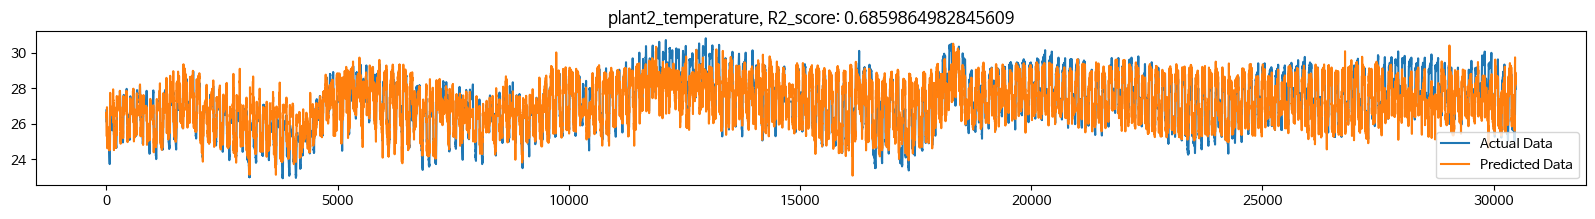

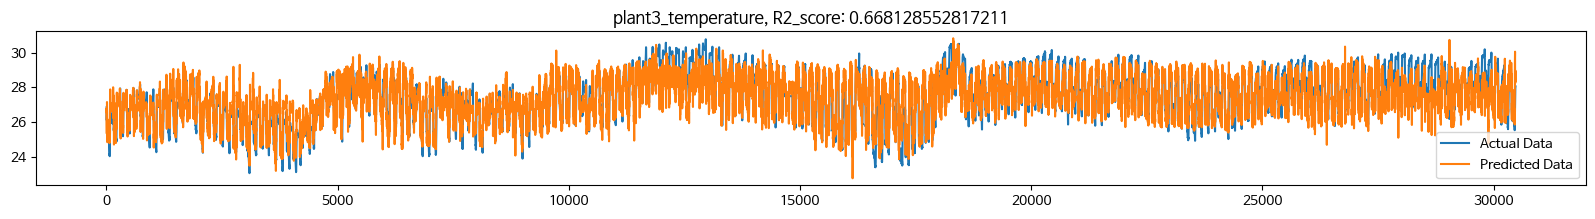

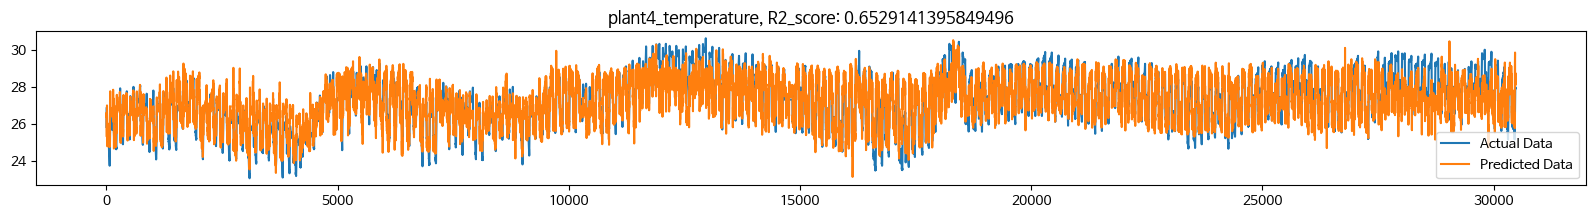

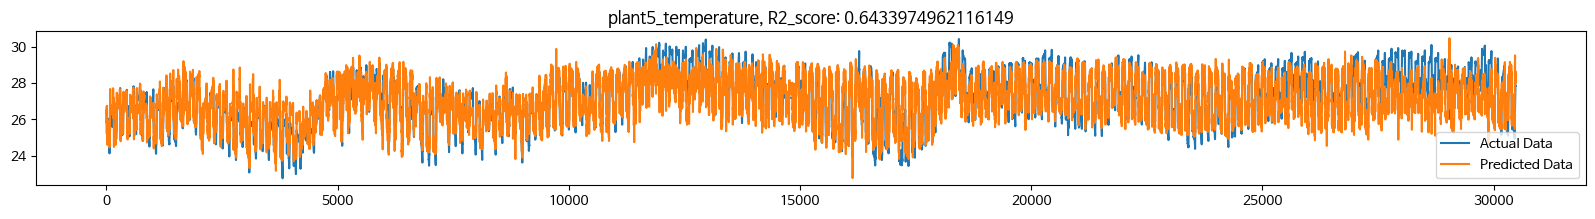

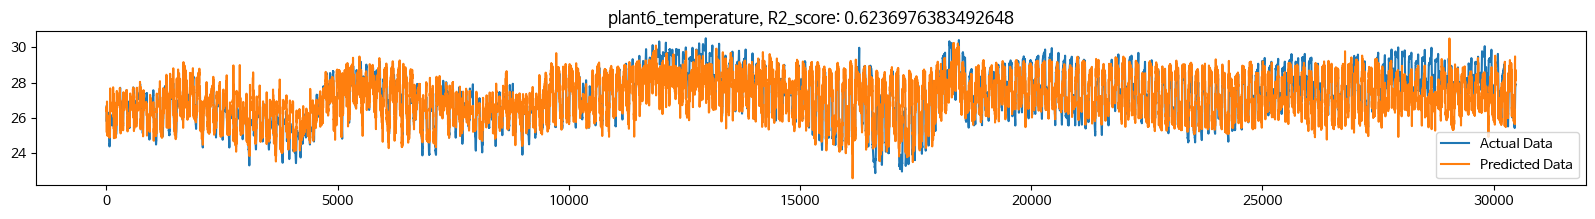

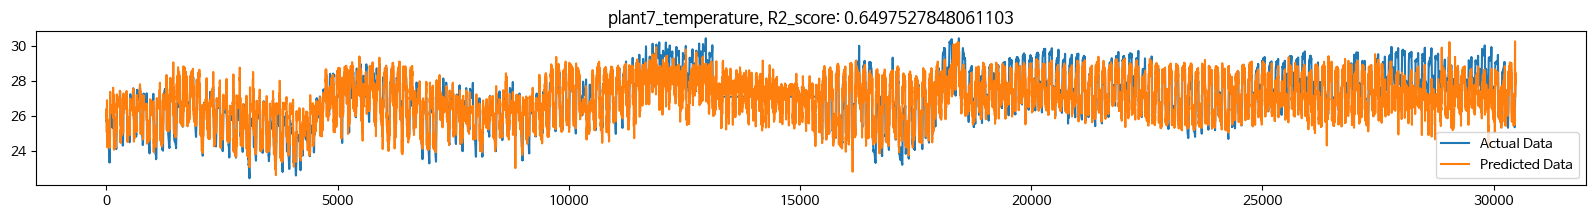

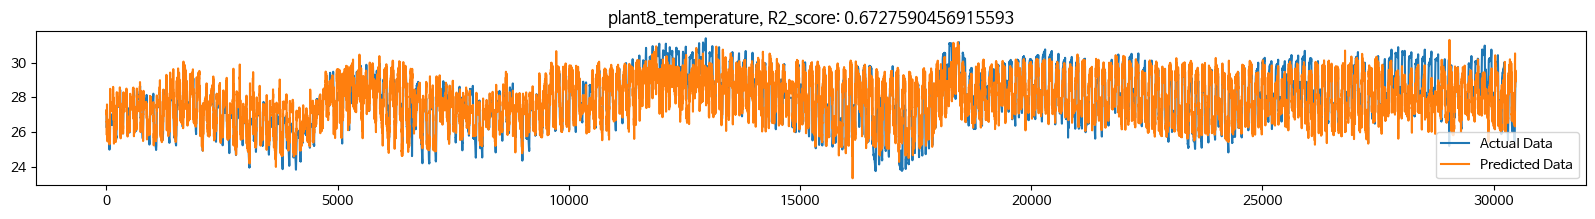

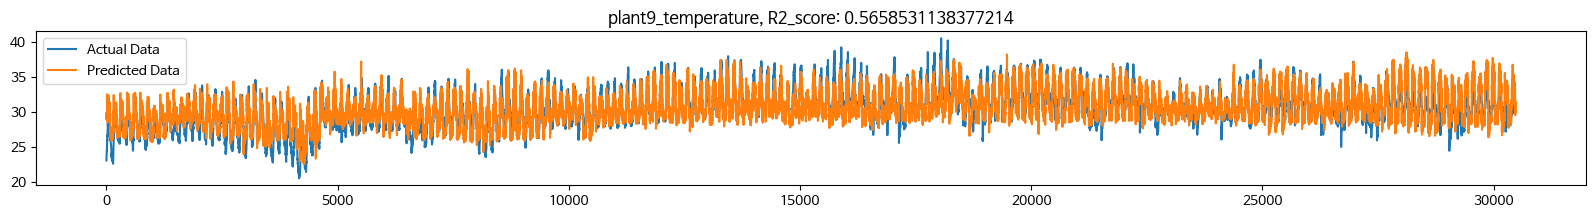

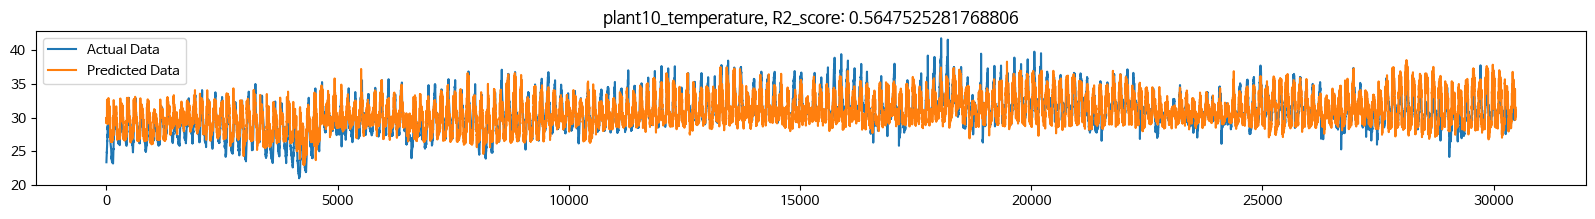

In [25]:
# plt.axvline(x=200, c='r', linestyle='--')

for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[:,i], label='Actual Data')
  plt.plot(predicted[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:,i], predicted[:,i])}')
  plt.legend()
  plt.show()

In [26]:
df_train.iloc[len_train:]

ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-06-19 15:20:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:30:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:40:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 15:50:00      45.0      35.0      45.0      45.0      40.0   
2023-06-19 16:00:00      45.0      35.0      45.0      45.0      40.0   
...                       ...       ...       ...       ...       ...   
2023-07-31 22:20:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:30:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:40:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 22:50:00       0.0       0.0       0.0       0.0       0.0   
2023-07-31 23:00:00       0.0       0.0       0.0       0.0       0.0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-06-19 15:20:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:30:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:40:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 15:50:00      45.0      45.0      45.0       45.0       45.0  ...   
2023-06-19 16:00:00      45.0      45.0      45.0       45.0       45.0  ...   
...                       ...       ...       ...        ...        ...  ...   
2023-07-31 22:20:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:30:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:40:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 22:50:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-07-31 23:00:00       0.0       0.0       0.0        0.0        0.0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-06-19 15:20:00               25.96               25.94   
2023-06-19 15:30:00               25.95               25.98   
2023-06-19 15:40:00               25.95               25.98   
2023-06-19 15:50:00               25.92               26.03   
2023-06-19 16:00:00               25.92               25.98   
...                                 ...                 ...   
2023-07-31 22:20:00               27.87               27.87   
2023-07-31 22:30:00               27.87               27.90   
2023-07-31 22:40:00               27.87               27.87   
2023-07-31 22:50:00               27.90               27.86   
2023-07-31 23:00:00               27.87               27.89   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-06-19 15:20:00               26.25            37.94               26.52   
2023-06-19 15:30:00               26.22            37.85               26.49   
2023-06-19 15:40:00               26.21            37.74               26.51   
2023-06-19 15:50:00               26.27            37.69               26.58   
2023-06-19 16:00:00               26.27            37.80               26.52   
...                                 ...              ...                 ...   
2023-07-31 22:20:00               28.05            39.65               28.79   
2023-07-31 22:30:00               28.05            40.04               28.80   
2023-07-31 22:40:00               28.04            39.95               28.83   
2023-07-31 22:50:00               28.04            40.38               28.84   
2023-07-31 23:00:00               28.05            40.60               28.87   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-06-19 15:20:00      

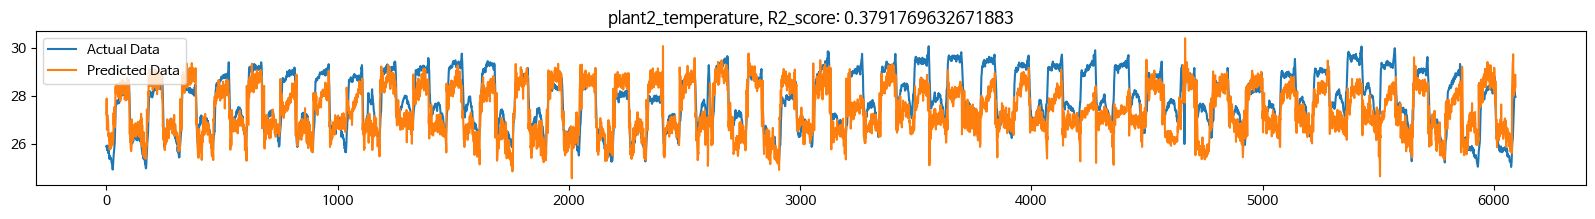

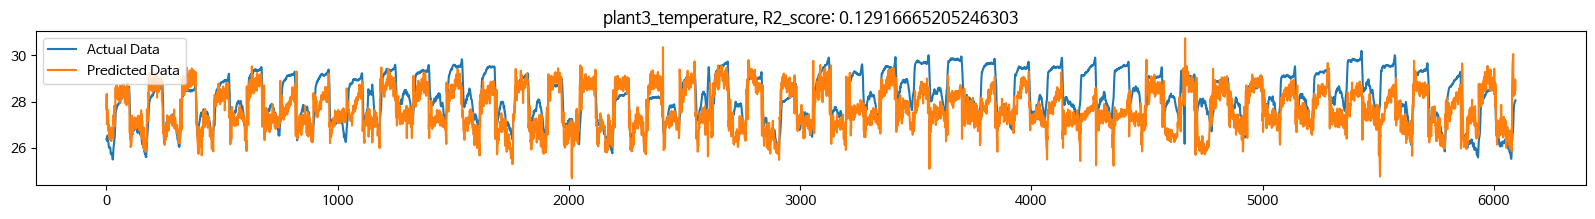

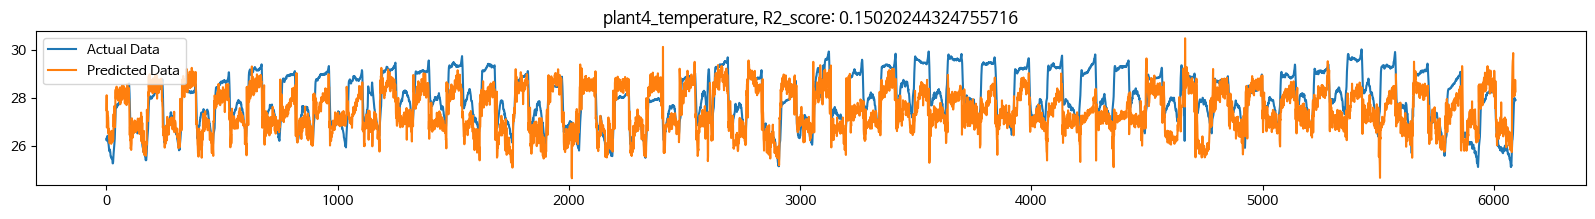

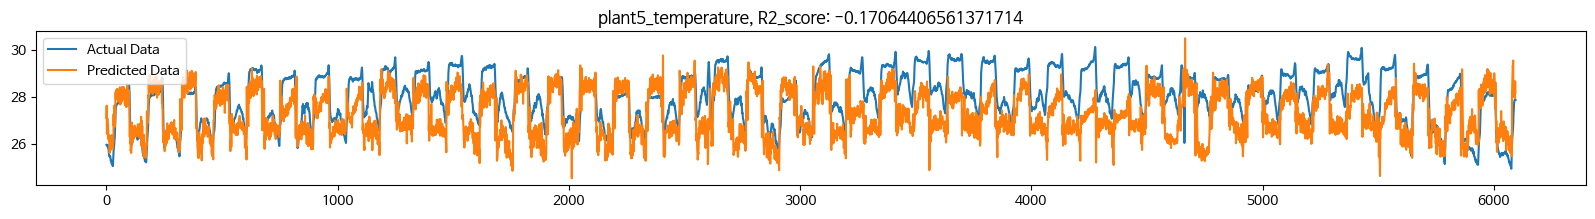

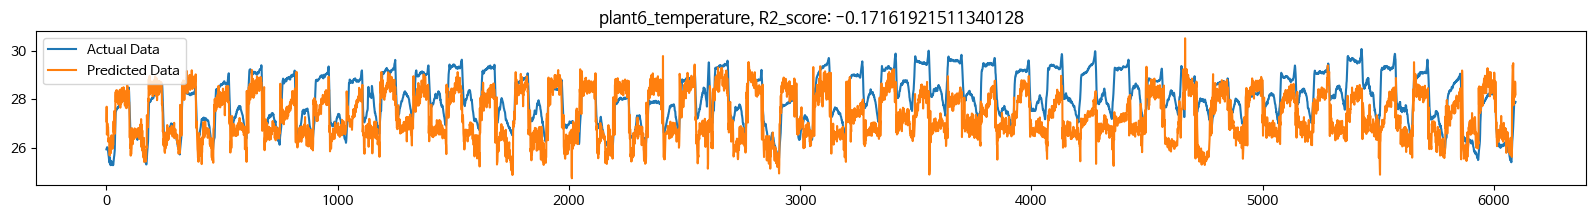

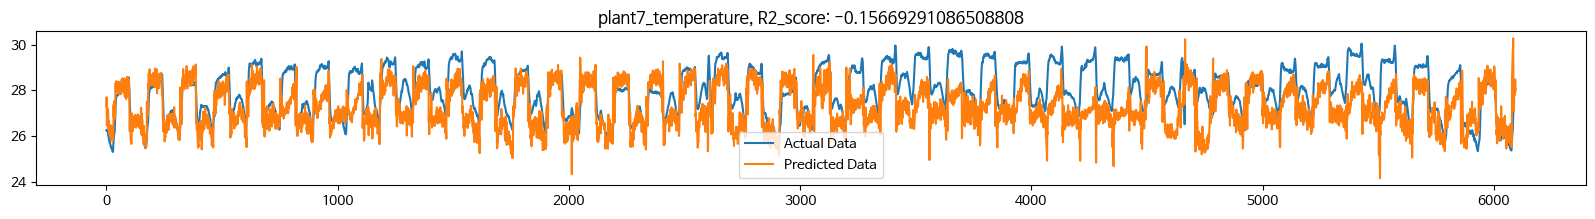

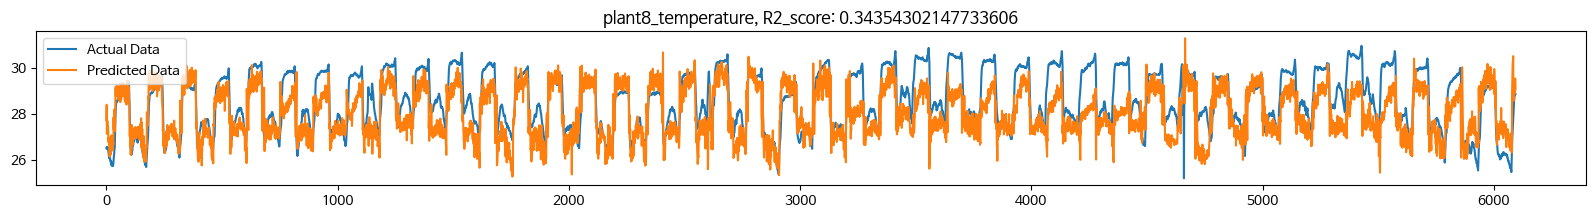

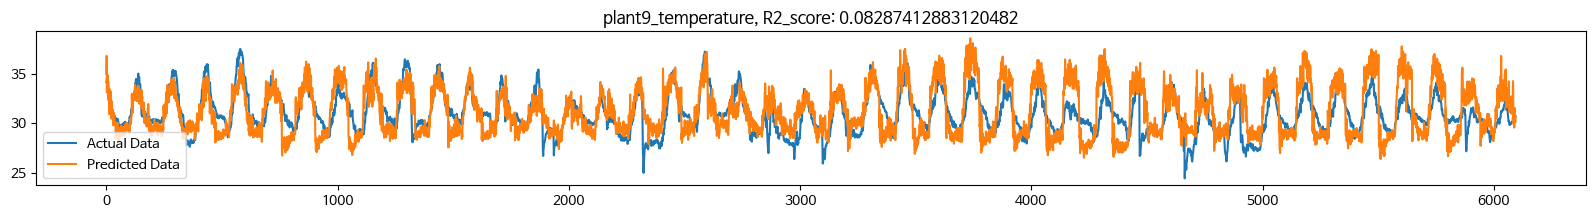

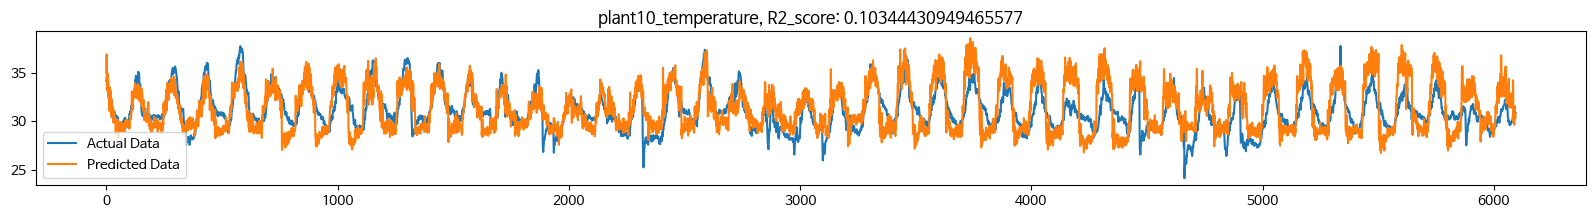

In [27]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(valid_y [:,i], label='Actual Data')
  plt.plot(gt_y[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(valid_y[:,i], gt_y[:,i])}')
  plt.legend()
  plt.show()

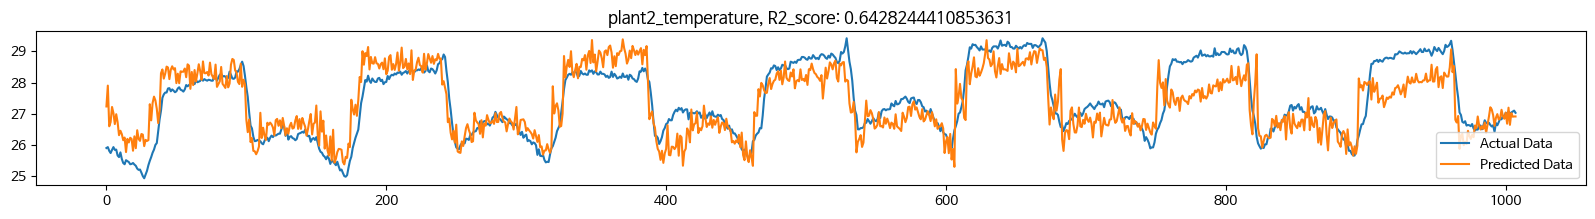

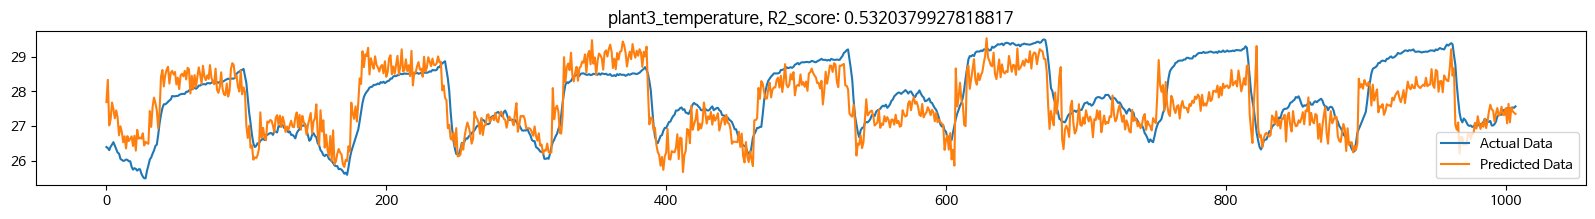

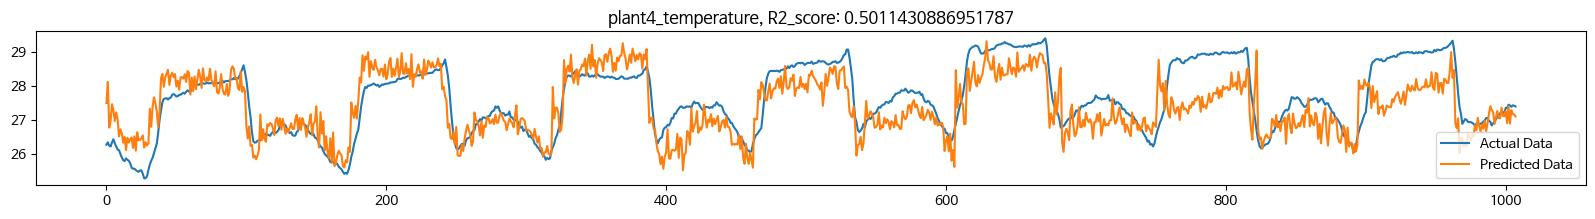

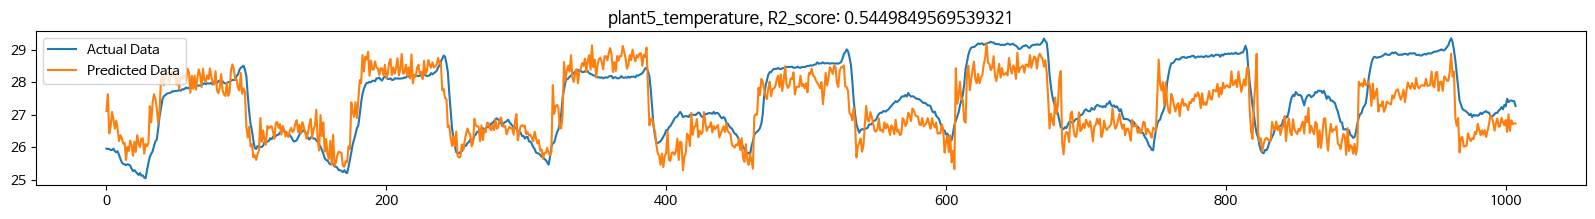

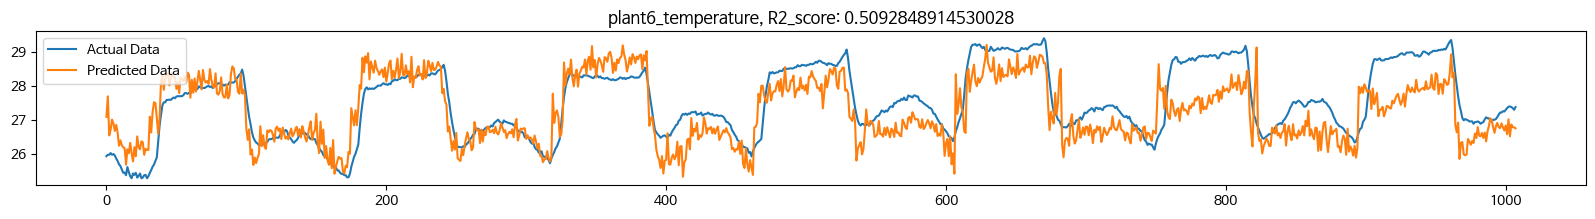

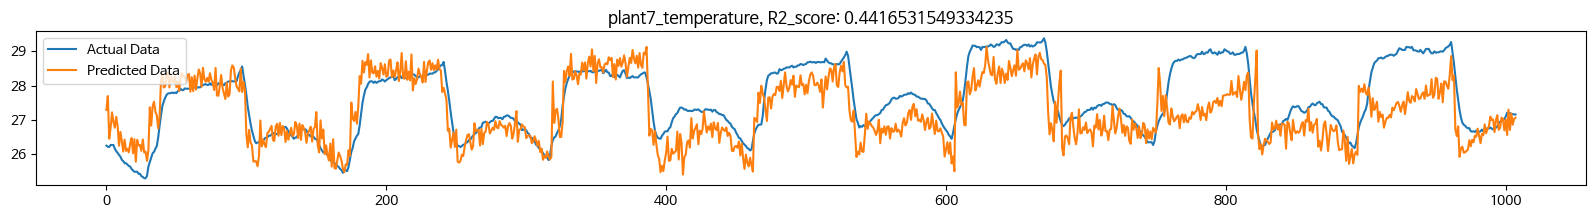

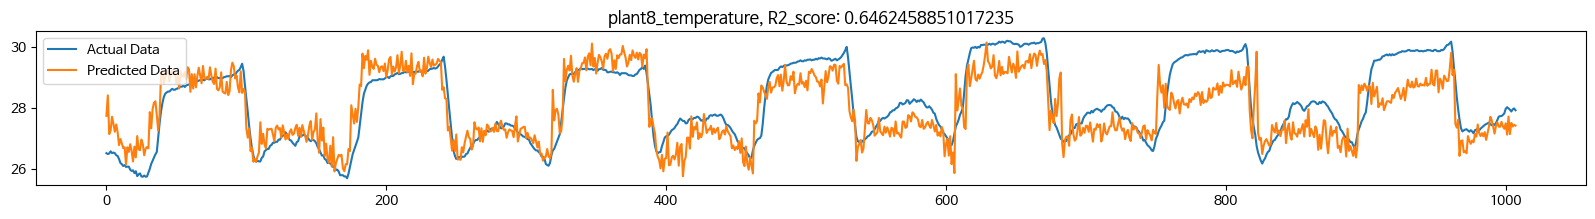

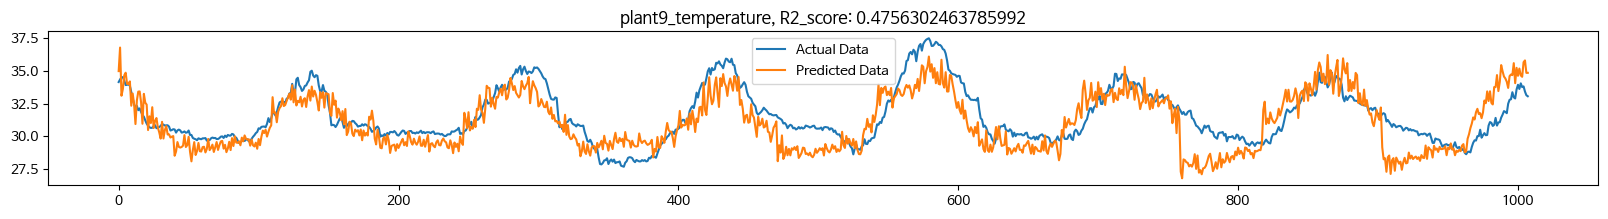

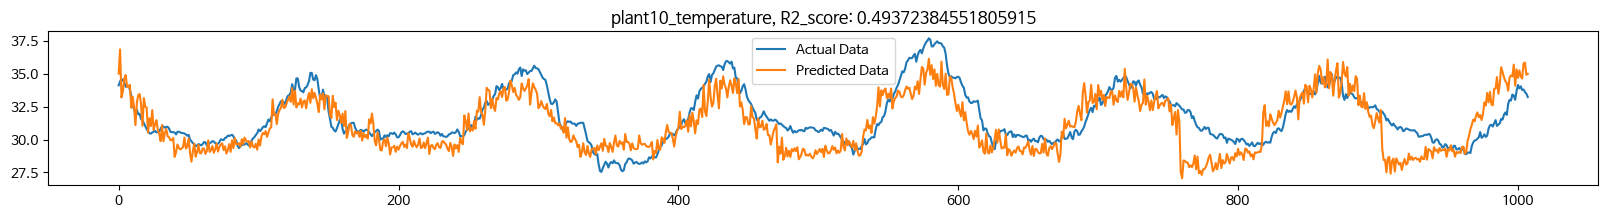

In [28]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(valid_y [:6*24*7,i], label='Actual Data')
  plt.plot(gt_y[:6*24*7,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(valid_y[:6*24*7:,i], gt_y[:6*24*7,i])}')
  plt.legend()
  plt.show()

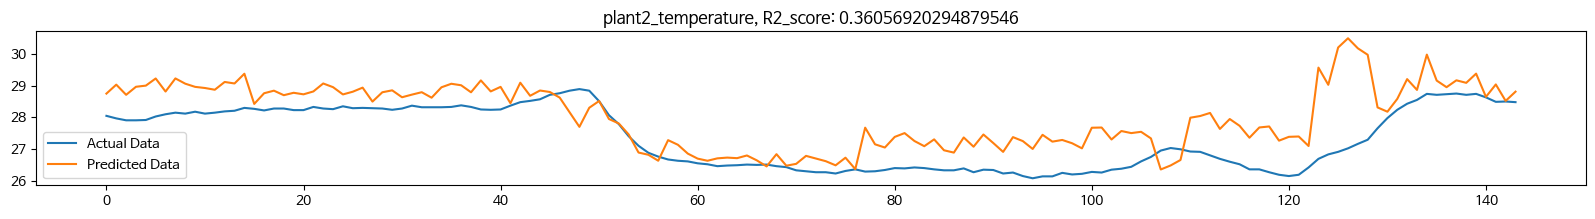

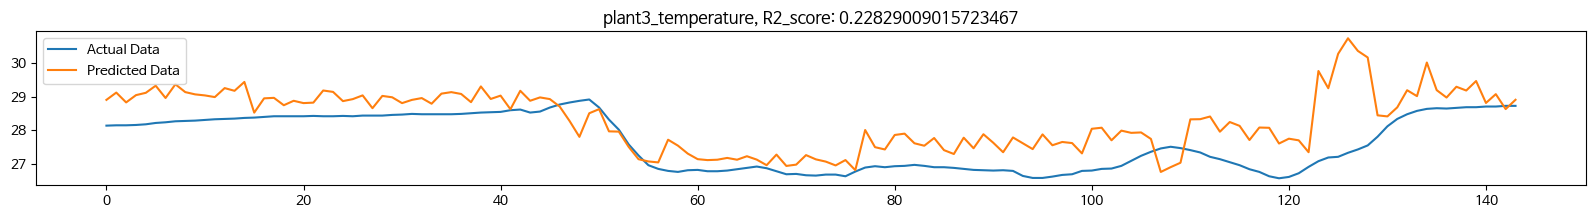

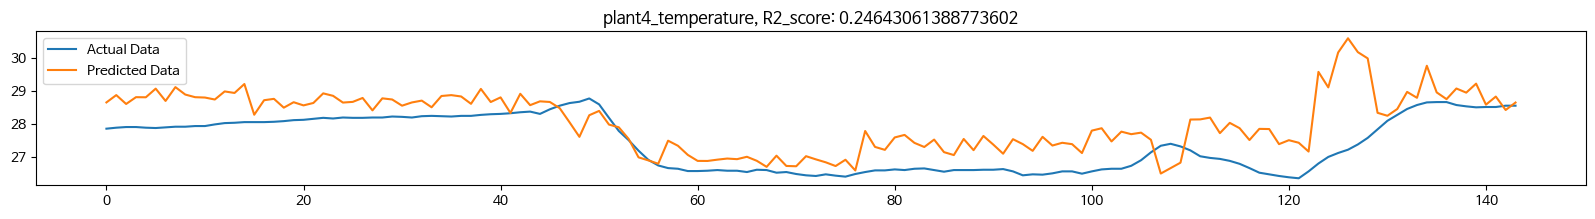

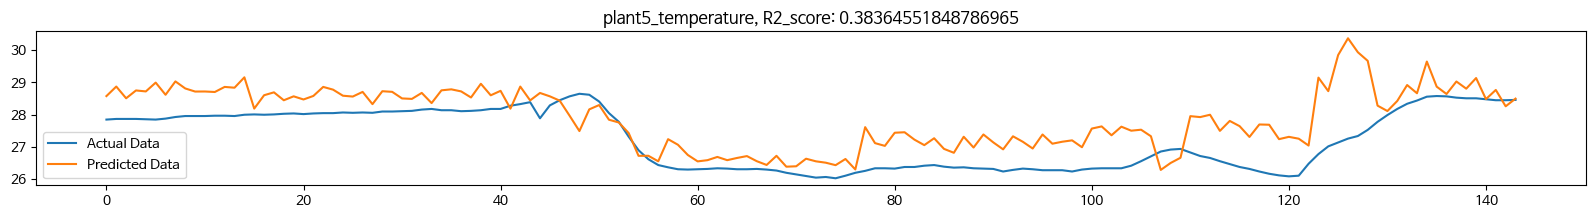

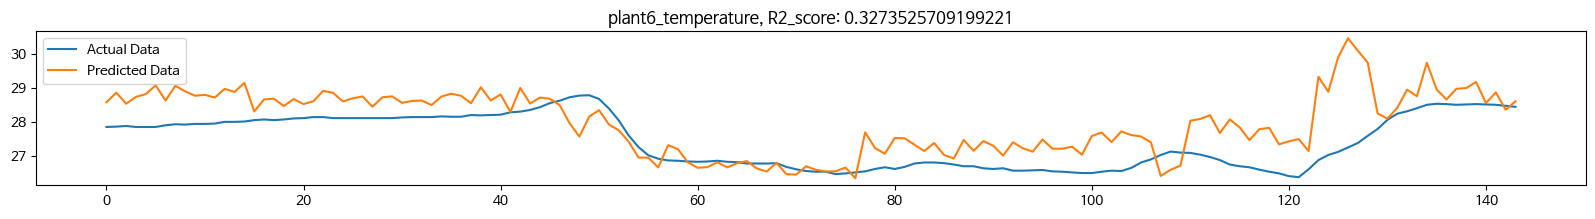

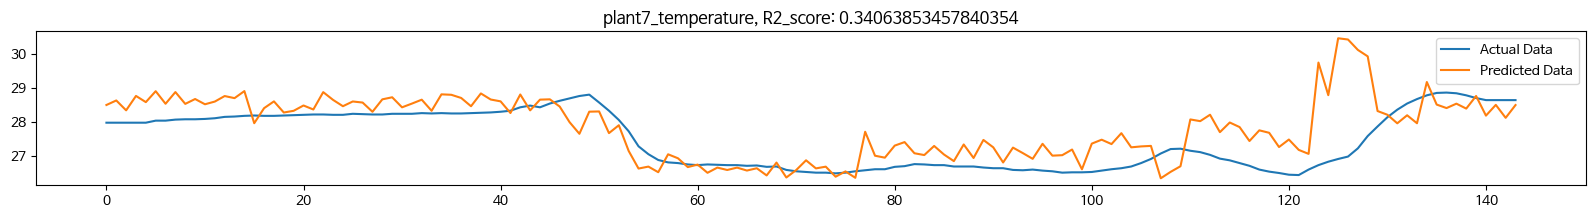

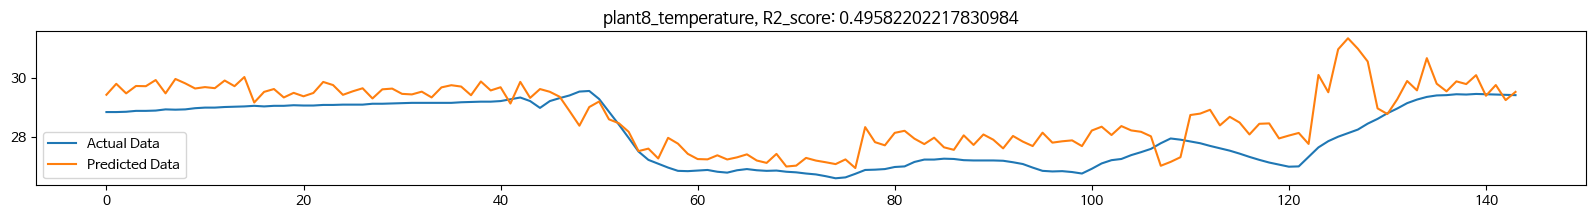

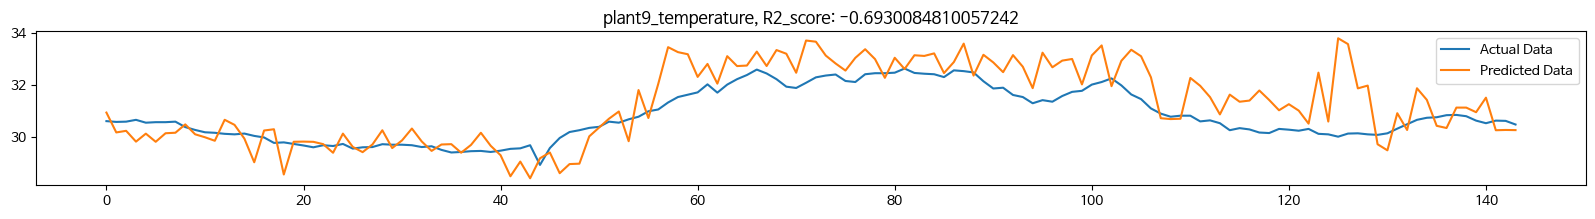

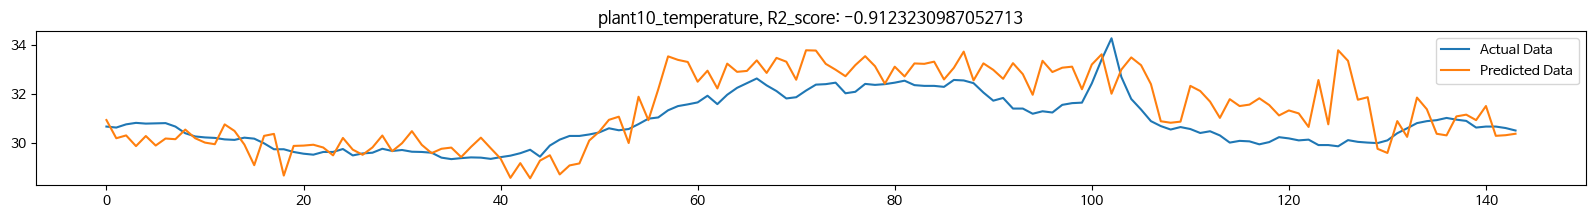

In [39]:
# plt.axvline(x=200, c='r', linestyle='--')

valid_y = label_y[len_train:,:]
gt_y = predicted[len_train: , :]


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(label_y[:6*24,i], label='Actual Data')
  plt.plot(predicted[:6*24,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:6*24*7,i], predicted[:6*24*7,i])}')
  plt.legend()
  plt.show()

# test

In [30]:
df_test

ahu1_inv  ahu2_inv  ahu3_inv  ahu4_inv  ahu5_inv  \
cdate                                                                   
2023-08-01 00:00:00       0.0       0.0       0.0       0.0       0.0   
2023-08-01 00:10:00       0.0       0.0       0.0       0.0       0.0   
2023-08-01 00:20:00       0.0       0.0       0.0       0.0       0.0   
2023-08-01 00:30:00       0.0       0.0       0.0       0.0       0.0   
2023-08-01 00:40:00       0.0       0.0       0.0       0.0       0.0   
...                       ...       ...       ...       ...       ...   
2023-09-30 23:10:00       0.0       0.0       0.0       0.0       0.0   
2023-09-30 23:20:00       0.0       0.0       0.0       0.0       0.0   
2023-09-30 23:30:00       0.0       0.0       0.0       0.0       0.0   
2023-09-30 23:40:00       0.0       0.0       0.0       0.0       0.0   
2023-09-30 23:50:00       0.0       0.0       0.0       0.0       0.0   

                     ahu7_inv  ahu8_inv  ahu9_inv  ahu10_inv  ahu11_inv  ...  \
cdate                                                                    ...   
2023-08-01 00:00:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-08-01 00:10:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-08-01 00:20:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-08-01 00:30:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-08-01 00:40:00       0.0       0.0       0.0        0.0        0.0  ...   
...                       ...       ...       ...        ...        ...  ...   
2023-09-30 23:10:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-09-30 23:20:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-09-30 23:30:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-09-30 23:40:00       0.0       0.0       0.0        0.0        0.0  ...   
2023-09-30 23:50:00       0.0       0.0       0.0        0.0        0.0  ...   

                     plant5_temperature  plant6_temperature  \
cdate                                                         
2023-08-01 00:00:00               27.85               27.85   
2023-08-01 00:10:00               27.87               27.86   
2023-08-01 00:20:00               27.87               27.88   
2023-08-01 00:30:00               27.87               27.85   
2023-08-01 00:40:00               27.86               27.85   
...                                 ...                 ...   
2023-09-30 23:10:00               28.04               27.74   
2023-09-30 23:20:00               28.04               27.74   
2023-09-30 23:30:00               28.03               27.76   
2023-09-30 23:40:00               28.01               27.76   
2023-09-30 23:50:00               28.01               27.74   

                     plant7_temperature  plant7_humidity  plant8_temperature  \
cdate                                                                          
2023-08-01 00:00:00               27.98            41.65               28.85   
2023-08-01 00:10:00               27.98            41.65               28.85   
2023-08-01 00:20:00               27.98            41.65               28.86   
2023-08-01 00:30:00               27.98            41.65               28.89   
2023-08-01 00:40:00               27.98            41.77               28.89   
...                                 ...              ...                 ...   
2023-09-30 23:10:00               27.81            46.00               28.87   
2023-09-30 23:20:00               27.81            46.04               28.85   
2023-09-30 23:30:00               27.81            46.13               28.83   
2023-09-30 23:40:00               27.80            46.15               28.81   
2023-09-30 23:50:00               27.80            46.15               28.83   

                     plant10_temperature  ahu13_inv  plant4_humidity  \
cdate                                                                  
2023-08-01 00:00:00      

In [31]:
yt = df_test.loc[:,target]
Xt = df_test.drop(columns=target)

df_x_ss = ss.transform(Xt)
df_y_ms = ms.transform(yt)

window_size = 6

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], window_size, -1))

df_x_ss = df_x_ss.to(device)

train_predict = model(df_x_ss)


predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

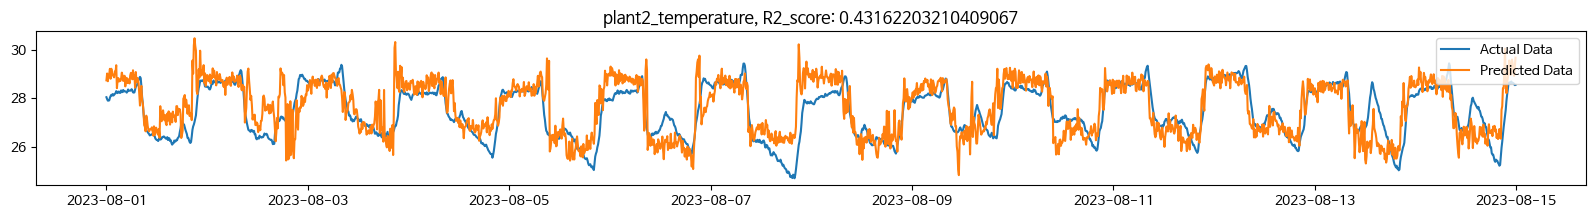

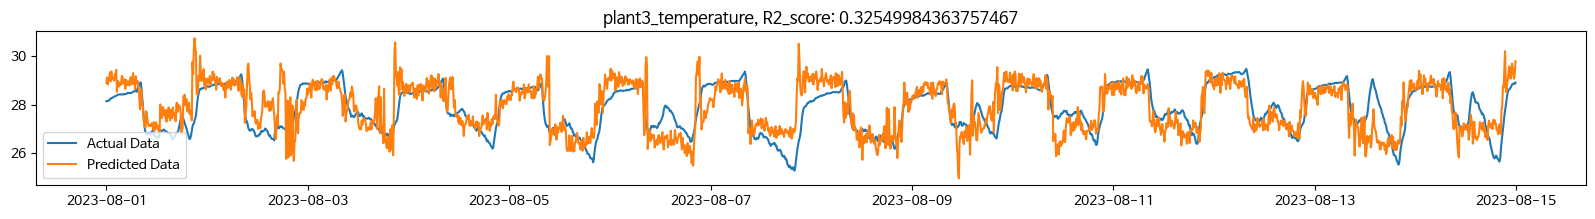

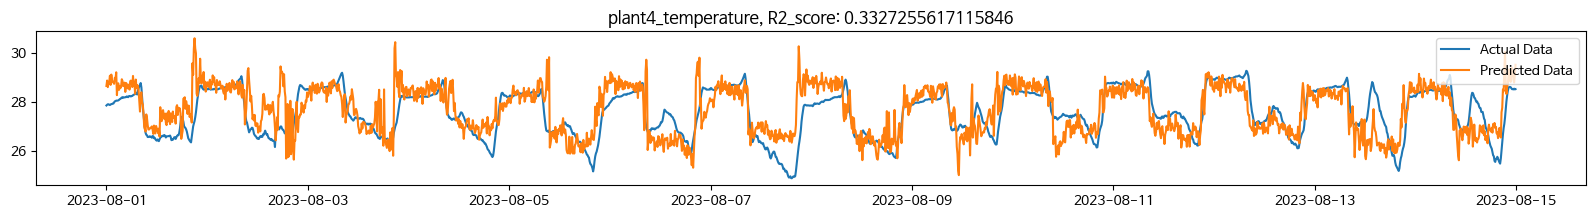

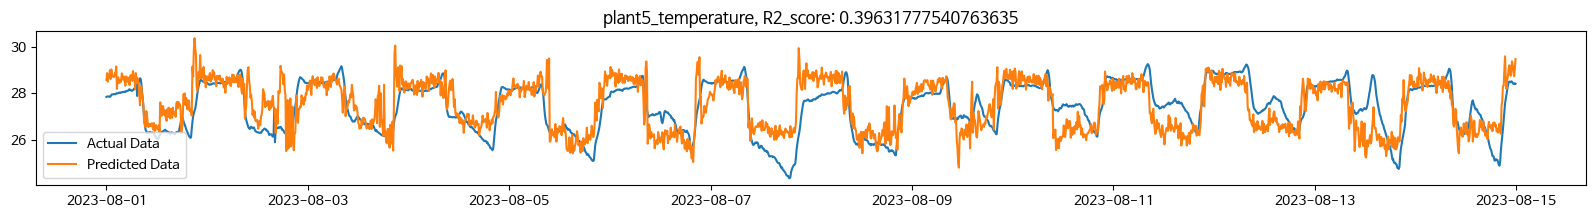

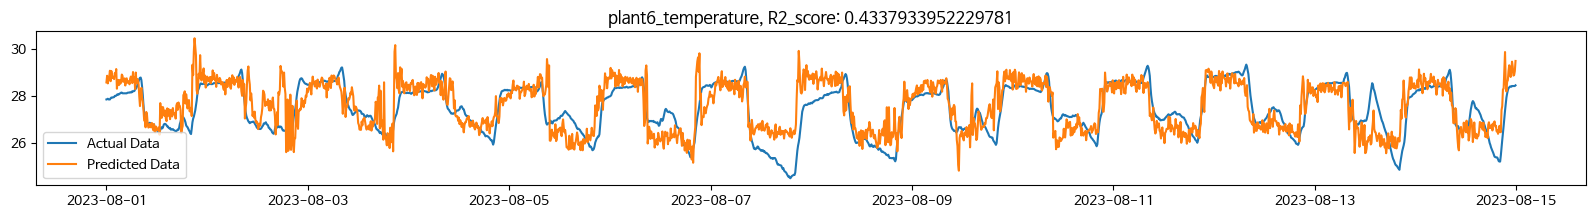

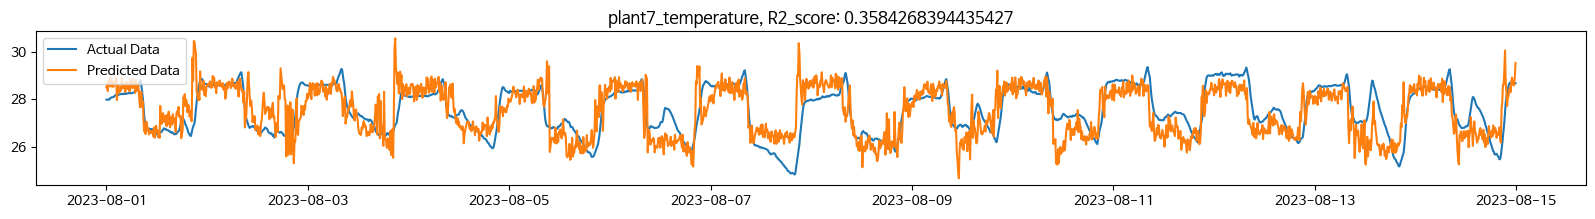

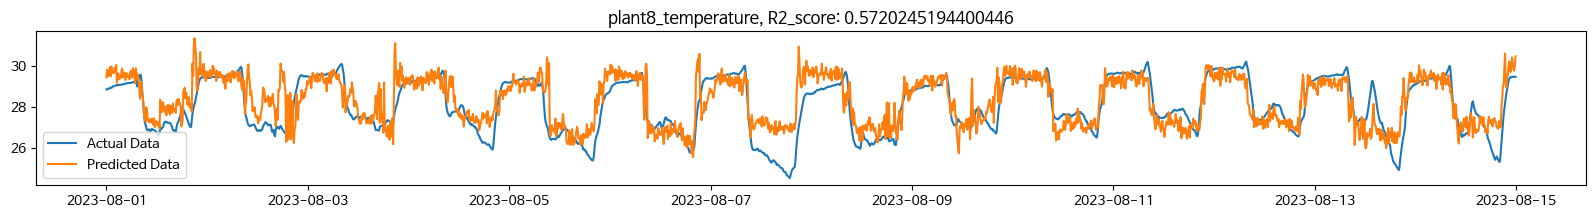

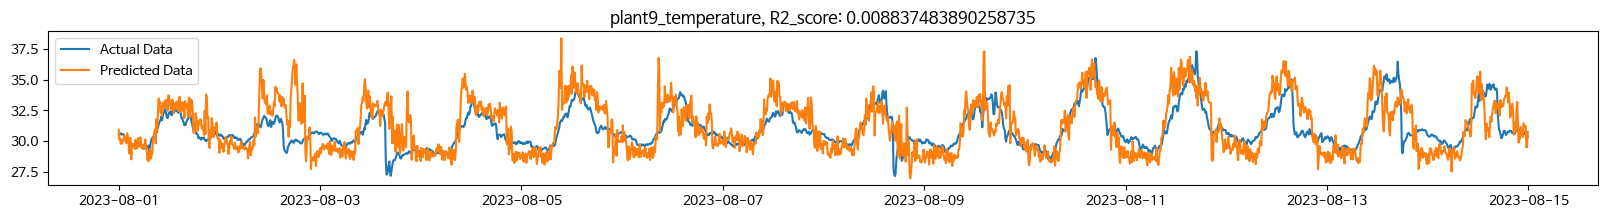

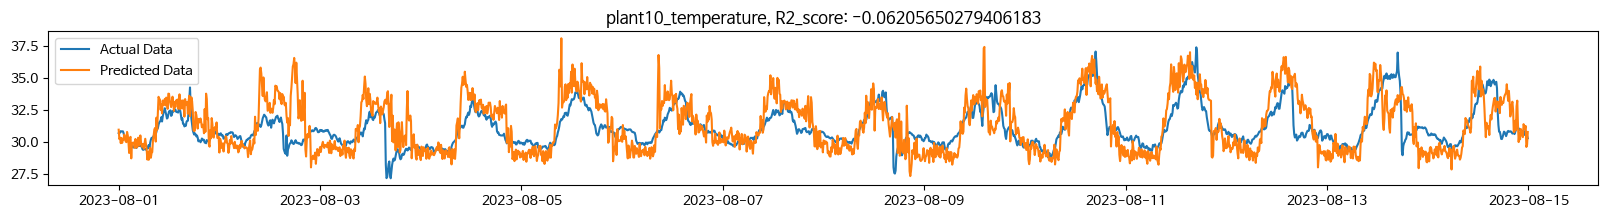

In [32]:
# plt.axvline(x=200, c='r', linestyle='--')
week2 = 2*7*24*6
start_date = "2023-08-01 00:00:00"
end_date = "2023-08-14 23:50:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(date_range, label_y[:week2,i], label='Actual Data')
  plt.plot(date_range, predicted[:week2,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:week2,i], predicted[:week2,i])}')
  plt.legend()
  plt.show()

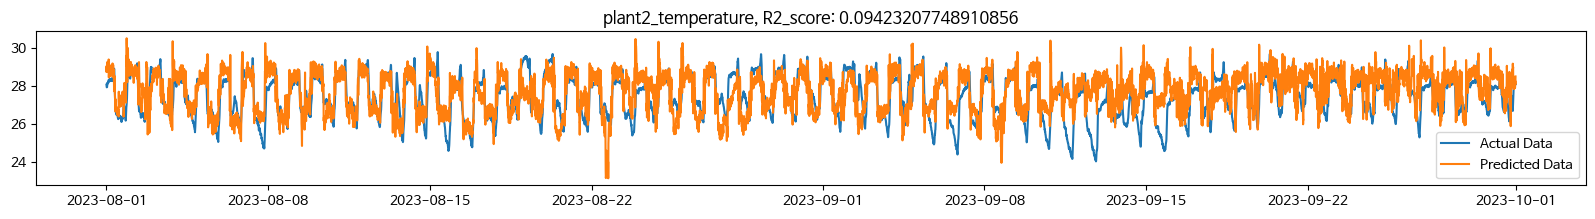

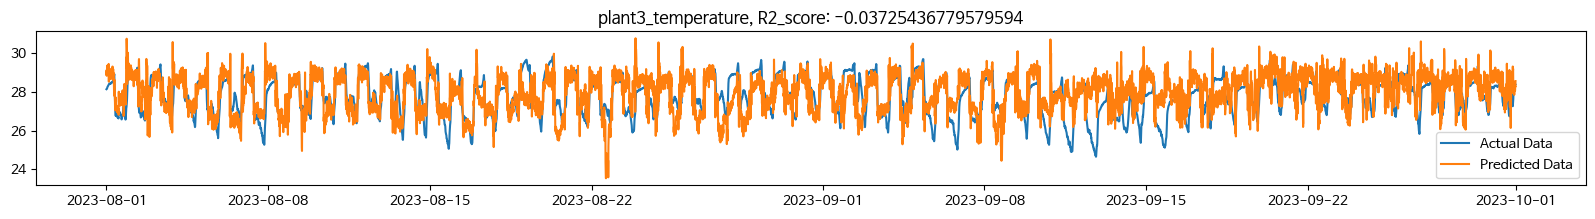

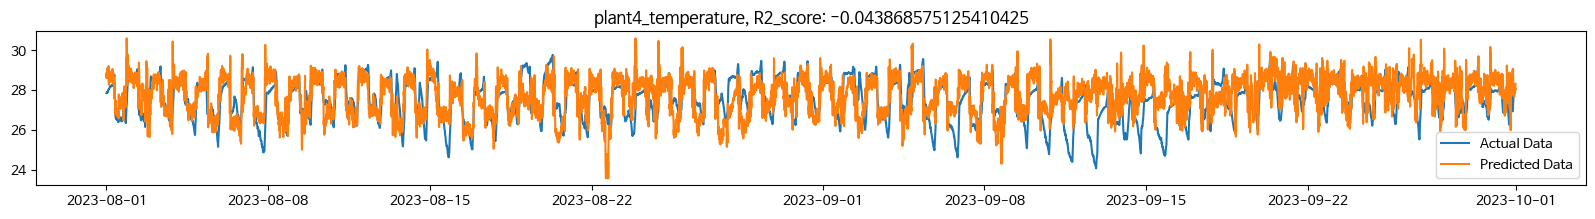

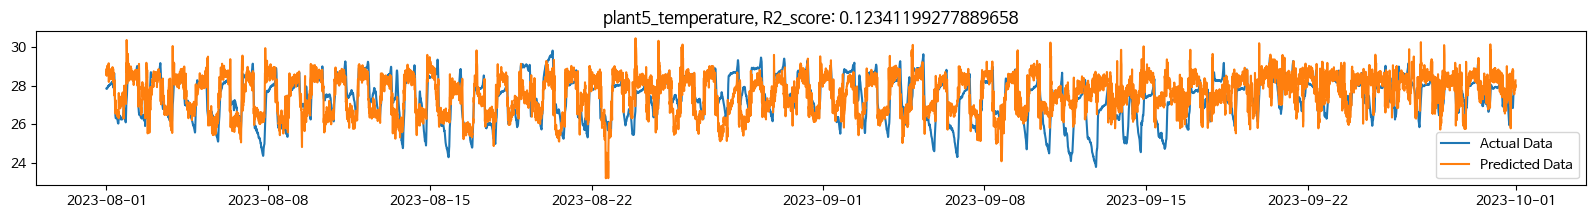

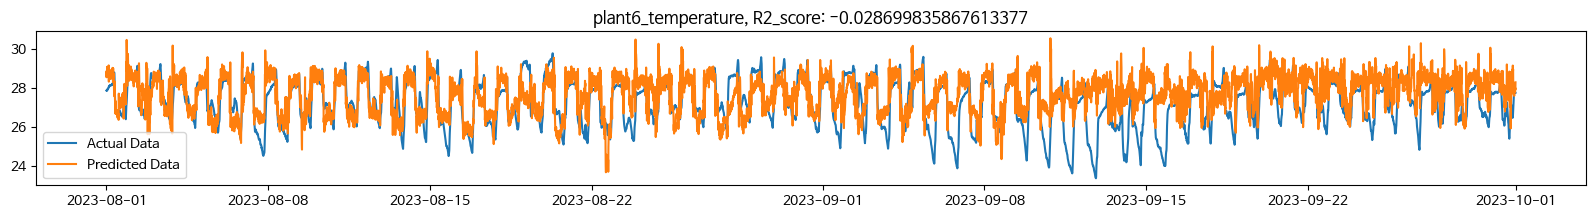

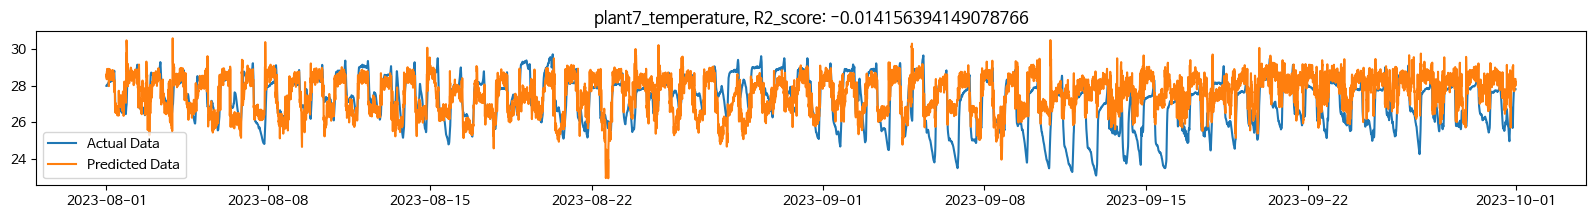

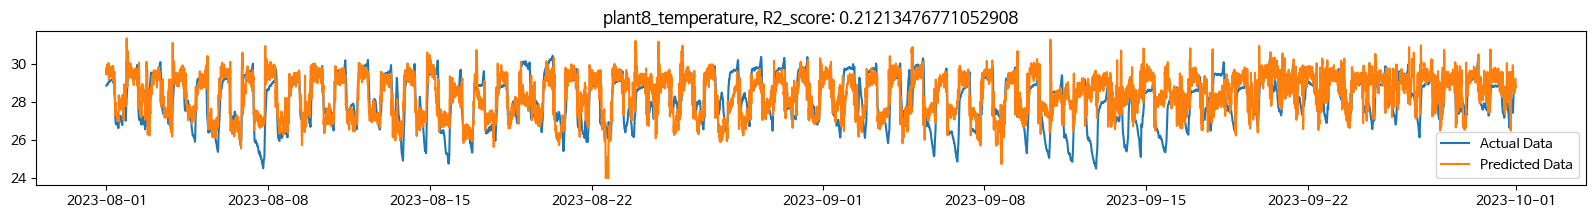

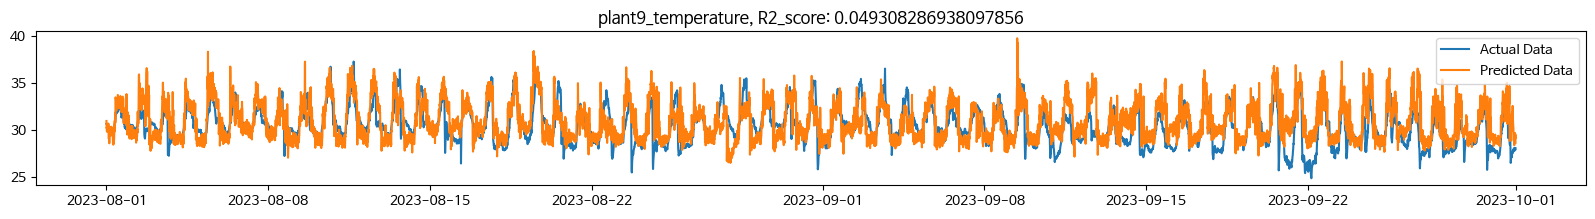

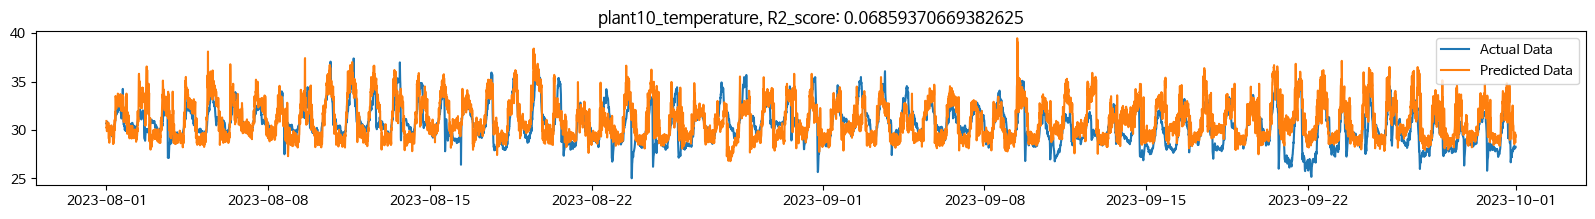

In [33]:
# plt.axvline(x=200, c='r', linestyle='--')
# week2 = 2*7*24*6
start_date = "2023-08-01 00:00:00"
end_date = "2023-09-30 23:50:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='10T')


for i in range(9):
  plt.figure(figsize=(20,2))
  plt.plot(date_range, label_y[:,i], label='Actual Data')
  plt.plot(date_range, predicted[:,i], label='Predicted Data')
  plt.title(f'plant{i+2}_temperature, R2_score: {r2_score(label_y[:,i], predicted[:,i])}')
  plt.legend()
  plt.show()

In [34]:
result = pd.DataFrame(columns=[f'plant{i+1}_temperature' for i in range(1,9)], index=pd.date_range(start=start_date, end=end_date, freq='10T'))
for i in range(9):
    result[f'plant{i+1}_temperature'] = label_y[:,i]

In [35]:
result.to_csv('result/temp_6win_3timestep_result.csv')